### Forecast

In [11]:
import os
from Pylice_def.data import page as data_page
import Pylice_def.data.preprocess as prep
from Pylice_def.forecast import modelling
from Pylice_def.forecast import forecasts
import pandas as pd 
import numpy as np 
from Pylice_def.queing import simulation as sim
from Pylice_def.queing import page as q_page
from Pylice_def.shift_scheduling import preprocess as sched_prep
from Pylice_def.shift_scheduling import page as shift_page
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import datetime as dt
import itertools as itr
import random as rd
from copy import copy
from tqdm import tqdm
import matplotlib.dates as mdates
import datetime
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as msq
import matplotlib.ticker as ticker

def optimization_preprocess(n_weeks, earliest_shift,latest_shift, allowed_lens, minimum_night, minimum_day, demand, f):
    allowed_lens = set(list(map(int, allowed_lens)))
    ts = sched_prep.horizon_timestamps(n_weeks,f)
    possible_shifts, starts_ends = sched_prep.create_possible_shifs(ts, sched_prep.create_forbidden_shifts(earliest_shift,latest_shift, f),allowed_lens, f)
    shifts_info = sched_prep.compute_shift_statistics(possible_shifts, f)
    shifts_info["Start_end"] = starts_ends
    possible_shifts = sched_prep.change_column_names(possible_shifts,ts,f)
    min_demand = sched_prep.create_min_demand(ts, minimum_night, minimum_day, f)
    shift_costs = shifts_info["cost"].copy(deep = True)
    shift_costs = shift_costs.to_dict()
    S = possible_shifts.index.tolist()
    ts = possible_shifts.columns.tolist()
    demand.index = ts
    min_demand.index = ts
    demand = pd.concat([demand, min_demand]).groupby(level=0).max().sort_index().to_dict()["Staffing_level"]
    shift_day_match_start, shift_day_match_end = sched_prep.match_starting_ending(ts, shifts_info)
    day_shift_match = sched_prep.create_coverage(possible_shifts)
    return ts, S, demand, shift_costs,day_shift_match, shift_day_match_start, shift_day_match_end, possible_shifts, shifts_info


def tabularize_results(model, shift_stats, ts_horizon, overlap, shift_lenghts, f):
    choosen = []
    for i in model.ShiftSelect:
        choosen.append((i,pyo.value(model.ShiftSelect[i]) , pyo.value(model.Allocated_Teams[i])))
    choosen = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
    choosen = choosen.loc[(choosen["selected"] > 0) & (choosen["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)
    choosen["start_num"] = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][0], choosen.index.tolist()))
    new_end = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][1] +1 , choosen.index.tolist()))
    for n, i in enumerate(new_end):
        if i == len(ts_horizon):
            new_end[n] = 0
    choosen["end_num"] = new_end
    choosen["start"] = choosen["start_num"].apply(lambda x: shift_page.from_num_to_date(x, f))
    choosen["end"] = choosen["end_num"].apply(lambda x :shift_page.from_num_to_date(x, f))
    choosen["len"] = (choosen["end"] - choosen["start"]).dt.seconds/(60*f)
    choosen = choosen[["staff", "start_num", "end_num", "len", "start", "end"]]
    choosen.sort_values("start_num", inplace = True)
    target = dt.timedelta(minutes = overlap)
    max_allowed_len = max(shift_lenghts)
    ##
    # shifts = shift_page.create_overlap(choosen, target, max_allowed_len)
    shifts = list(map(list, choosen.reset_index().to_numpy()))
    shifts = pd.DataFrame(shifts)
    ##
    shifts.columns = choosen.reset_index(names= ["Shift_name"]).columns
    shifts.drop("len", axis = 1, inplace = True)
    shifts.set_index("Shift_name", inplace = True)
    shifts["start-end"] = shifts["start"].dt.time.astype(str) +  " - " + shifts["end"].dt.time.astype(str)

    layover = shifts[shifts["start_num"] > shifts["end_num"]].index.tolist()
    for ind in layover:
        shifts.loc[f"{ind}-->"] =   shifts.loc[ind, "staff"],\
                                    shifts.loc[ind, "start_num"],\
                                    0,\
                                    shifts.loc[ind, "start"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "start-end"]
        
        shifts.loc[f"-->{ind}"] =   shifts.loc[ind, "staff"],\
                                    0,\
                                    shifts.loc[ind, "end_num"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "end"],\
                                    shifts.loc[ind, "start-end"]
        shifts.drop(ind, inplace = True)

    shifts["len"] = (shifts["end"] - shifts["start"]).dt.seconds/(60*15)
    coverage = shifts[["staff", "start", "end"]].copy()
    ts_ = list(pd.date_range(start = "2023-01-01 00:00:00", end= "2023-01-08 00:00:00", freq = "15min"))
    shifts["start_num"] = shifts["start"].apply(lambda x: (ts_.index(x)))
    shifts.drop(["start", "end"], axis = 1, inplace = True)
    layover = shifts.loc[shifts["len"] < 0].index.tolist()
    for i in layover:
        shifts.loc[i, "len"] = len(ts_) - shifts.loc[i, "start_num"] ###
    shifts['color'] = shifts.apply(lambda df: shift_page.color(df), axis=1)
    shifts.reset_index(names = ["Shift_name"], drop = False, inplace= True)
    shifts.sort_values("start-end", inplace = True, ascending= False)
    print(f"Maximum shift length is respected: {(shifts.len > 4* max_allowed_len).unique().tolist() == [False]}")
    shifts["end_num"] = shifts["start_num"] + shifts["len"] 
    return shifts, coverage


def run_test(call_type, timeframe, horizon, gap):
    today = pd.to_datetime("2023-01-01 00:00:00")
    to_date = today + datetime.timedelta(weeks= gap)

    file_name =  "112_Innlandet"#"112_Soer_Oest"#

    ### IMPORT
    data = []
    for file in os.listdir(f"..\data\List_Raw\\{file_name}"):
        file = f"..\\data\\List_Raw\\{file_name}\\{file}"
        if call_type in file:
            data.append(data_page.import_file(file))

    ### Prepare
    a, data, b, c = prep.prepare_data(data, timeframe)
    # # print(data)
    # if call_type == "112":
    #     data = data[0]
    # elif call_type == "02800":
    #     data = data[1]
    data = data[0]
    ### Forecast
    x_train, y_train, x_test, y_test = modelling.custom_train_test_split(data.copy(deep = True), s_start= pd.to_datetime("2023-01-07 00:00:00"), horizon = 9)
    model = modelling.xgb_model()
    model.fit(x_train, y_train)  
    test_pred = copy(model.predict(x_test).flatten())

    X_train = data.copy(deep = True)
    Y_train = X_train.pop("Calls")
    # pred_train = copy(model.predict(x_test).flatten()) # RESULTS 
    model.fit(X_train, Y_train)
    pred_train = copy(model.predict(X_train).flatten()) #MDA1
    # pred_train = copy(model.predict(x_test).flatten()) #MDA2 x_test -> pre_train vs y_test
    from_date = to_date
    future_dates = forecasts.create_horizon_dates(from_date, horizon, timeframe)
    future_data = forecasts.create_horizon_data(future_dates)
    predictions = model.predict(future_data)
    predictions = forecasts.create_prediction_output(future_dates, predictions, call_type)
    return (X_train.index, pred_train),predictions#,modelling.wape(y_test, pred_train)) # MDA2
    # return ((y_test, pred_train),predictions)# RESULTS
    # return (modelling.mae(Y_train, pred_train),modelling.wape(Y_train, pred_train))# MDA1


In [12]:
# t_unit = [15, 30, 60]
# w_size = [6, 9, 12]#[9]#
# g_size = [1, 3, 5]#[2]#
# call_type = ["112", "02800"]
# results = []
# for timeframe in t_unit:
#     for horizon in w_size:
#         for gap in g_size:
#             for call in call_type:
#                 results.append((call, timeframe, horizon, gap, *run_test(call_type= call, timeframe= timeframe, horizon= horizon, gap= gap)))
                

# results = pd.DataFrame.from_records(results, columns= ["Call_type", "TimeUnit", "Horizon", "Gap", "MAE", "WAPE"])
# X = ["TimeUnit"]
# Ys = ["MAE", "WAPE"]
# colors = ["red", "blue",]
# row = 0
# fig, axs = plt.subplots(1,len(Ys), figsize = (8,4))

# # fig.suptitle("Sør-Øst")
# fig.suptitle("Innlandet")
# fig.tight_layout(h_pad= 8)
# for col, Y in enumerate(Ys):
#         for c, call in enumerate(call_type):
#             # print(f"Position: {row, col}", "|TimeUnit", t, "|X: ", X, "|Y: ", Y)
#             sub = results.loc[(results["Call_type"] == call)].copy()
#             if call == "112":
#                 style = "solid"
#             else:
#                 style = "dashed"
#             axs[col].plot(sub[X], sub[Y], linestyle = style, color = colors[c], zorder = c, label = f"{call} calls")
#             # axs[row][col].set_title(Y)
#             axs[col].set_xlabel(X[0])
#             axs[col].set_ylabel(Y)
#             axs[col].legend(fontsize="8")
#             axs[col].set_xticklabels = ["15", "30","45", "60"]
#             axs[col].set_xticks(list(range(0, 61, 15)))
# fig.tight_layout(h_pad= 8)
# plt.show()


In [13]:
# # t_unit = [15]#[15, 30, 60]
# # w_size = [9]#[6, 9, 12]
# # g_size = [2]#[1, 3, 5]
# # call_type = ["112", "02800"]
# # results = []
# # for timeframe in t_unit:
# #     for horizon in w_size:
# #         for gap in g_size:
# #             for call in call_type:
# #                 results.append((call, timeframe, horizon, gap, *run_test(call_type= call, timeframe= timeframe, horizon= horizon, gap= gap)))
# # results # h = 9, gap = 2, t = 15
# fig, axs = plt.subplots(1, 2, figsize = (12,6), sharex= False)
# for run in results:
#     # plt.xticks(rotation=60)
#     call, t, horizon, gap, test, values2 = run
#     y_test, pred_test = test
#     pred_test = list(map(round, pred_test))
#     y_test = pd.DataFrame(y_test)
#     y_test["Predictions"] = pred_test 
#     print(f"{call} - WAPE at 15min level: ", modelling.wape(y_test.Predictions, y_test.Calls))
#     y_test = y_test.resample("20h").mean()
#     values2 = values2.resample("20h").mean()

#     if call == "112":
#         col = 0
#     else: 
#         col = 1

#     axs[col].plot(y_test.index, y_test.Calls, label = "Actual Values", color = "seagreen")
#     axs[col].plot(y_test.index, y_test.Predictions, label = "Test Predictions", color = "deepskyblue")
#     axs[col].plot(values2.index, values2.Predictions, label = "Fututre predictions", color = "tomato")
#     axs[col].set_xticks(ticks = ["2022-11", "2022-12", "2023-01", "2023-02", "2023-03"])
#     axs[col].set_xticklabels(["2022-11", "2022-12", "2023-01", "2023-02", "2023-03"] , rotation = 45)
#     axs[col].set_title(f"{call} Calls")
#     axs[col].legend()
#     axs[col].set_ylabel("Average number of calls (calls/15min)")
#     axs[col].set_xlabel("$Time$")
#     print(f"{call} - WAPE at Daily level: ", modelling.wape(y_test.Predictions, y_test.Calls))
# plt.show()


In [18]:
t_unit = [15, 30, 60]
w_size = [6, 9, 12]
g_size = [1, 3, 5]
call_type = ["112", "02800"]
results = []
values = []
for timeframe in t_unit:
    for horizon in w_size:
        for gap in g_size:
            for call in call_type:
                res = run_test(call_type= call, timeframe= timeframe, horizon= horizon, gap= gap)
                results.append((call, timeframe, horizon, gap, *res))
                # values.append((call, timeframe, horizon, gap, res[-1]))
                
# values = pd.DataFrame.from_records(values, columns= ["Call_type", "TimeUnit", "Horizon", "Gap", "WAPE"])


two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type
two types
only one type


C:\Users\loren\AppData\Local\Temp\ipykernel_30040\1109234783.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row][col].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
C:\Users\loren\AppData\Local\Temp\ipykernel_30040\1109234783.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row][col].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
C:\Users\loren\AppData\Local\Temp\ipykernel_30040\1109234783.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row][col].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
C:\Users\loren\AppData\Local\Temp\ipykernel_30040\1109234783.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[row][col].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
C:\Users\loren\AppData\Local\Temp\ipykernel_30040\1109234783.py:39: UserWarning: FixedFormatter should only be used together with Fi

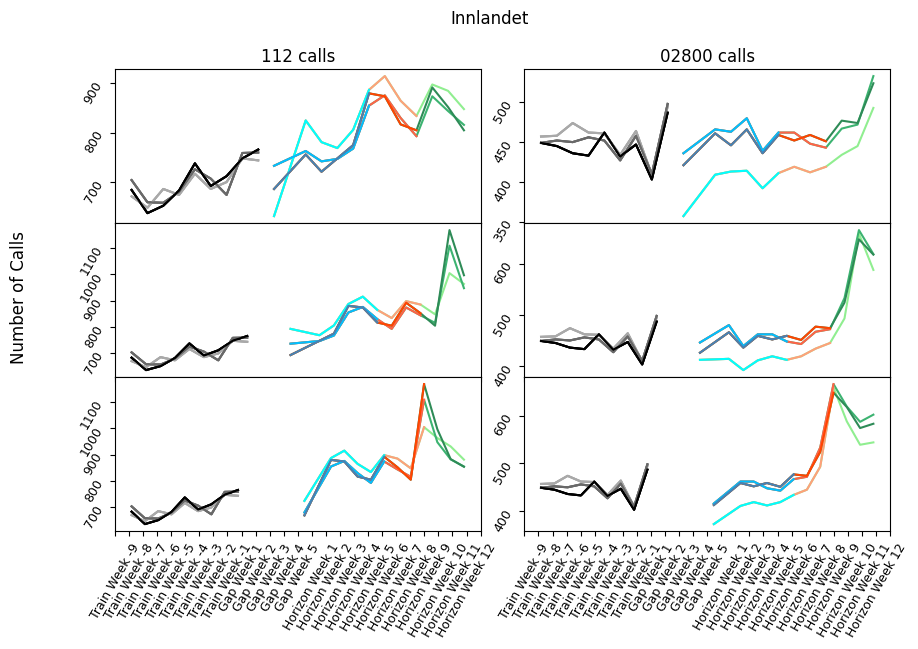

In [19]:

#### MDA
colors_TS = { w_size[0] : { 15 : "aqua", 30 : "deepskyblue", 60 : "steelblue"},
              w_size[1] : { 15 : "lightsalmon", 30 : "tomato", 60 : "orangered"},
              w_size[2] : { 15 : "lightgreen", 30 : "mediumseagreen", 60 : "seagreen"}}
colors_TR = {15 : "darkgrey", 30 : "dimgrey", 60 : "black"}

fig, axs = plt.subplots(3, 2, figsize = (10,6), sharex= False)
# fig.tight_layout(h_pad= 1.5)

fig.subplots_adjust(wspace= .12, hspace=0)
fig.suptitle("Innlandet")
fig.supylabel("Number of Calls", )
for run in results:
    # plt.xticks(rotation=60)
    call, t, horizon, gap, preds, values2 = run
    time1, values1 = preds
    values2 = values2.resample("60min").sum()
    values1 = pd.Series(index= time1, data= values1, name= "Predictions").resample("60min").sum()
    values2.Predictions.clip(values1.values.min(), inplace= True)

    values1 = values1.astype(int)
    values2 = values2.astype(int)

    values1 = values1.resample("W").sum().iloc[-9:]
    values2 = values2.resample("W").sum()

    values2.iloc[0] = values2.iloc[1] + ( - values2.iloc[2] + values2.iloc[1])
    col = call_type.index(call)
    row = g_size.index(gap)
    axs[row][col].plot(values1.index.tolist(), values1.values, color = colors_TR[t], label = f"Train - TimeUnit: {t}", zorder = horizon)
    axs[row][col].plot(values2.index.tolist(), values2["Predictions"], color = colors_TS[horizon][t], label = f"Predictions - TimeUnit: {t}", zorder = abs(w_size.index(horizon) - len(w_size)))

    # print(horizon + 1 + 9 + gap)  
    # axs[row][col].set_xticks(range(9 + gap + horizon + 1))
    xlabels =   [f"Train Week {n}" if row == 2 else "" for n in range(-9,0) ] + \
                [f"Gap Week {n}" if row == 2 else "" for n in range(1,(gap+1))] + \
                [f"Horizon Week {n}" if row == 2 else "" for n in range(1,horizon +1)]
    
    axs[row][col].xaxis.set_major_formatter(ticker.FixedFormatter(xlabels))
    axs[row][col].tick_params(labelrotation=60, labelsize = 9)
    axs[row][col].xaxis.set_major_locator(ticker.LinearLocator(9 + gap + horizon + 1))

    if row == 0:
        axs[row][col].set_title(f"{call} calls" )

    handles, labels = plt.gca().get_legend_handles_labels() # axs[row][col]
    order = [0,3,1,4,2,5]
    
# axs[0][0].legend()#[handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()
    